# Chest X-ray Multi-Label Disease Classification With TransCheX 

This tutorial demonstrates how to construct a training workflow of TransCheX model [1] for chest X-ray multi-label disease classification using Open-I dataset. The TransCheX is multi-modal transformer-based model consisting of vision, language and mixed modality encoder that is designed for chest X-ray image classification.

The Open-I dataset provides a collection of 3,996 radiology reports with 8,121 associated images in PA, AP and lateral views. In this tutorial, we utilize the images from fronal view with their corresponding reports for training and evaluation of the TransChex model.The 14 finding categories in this work include Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged-Cardiomediastinum, Fracture, Lung-Lesion, Lung-Opacity, No-Finding, Pleural-Effusion, Pleural-Other, Pneumonia, Pneumothorax and Support-Devices. More information can be found in the following link:      
https://openi.nlm.nih.gov/faq

License: Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)

An example of images and corresponding reports in Open-I dataset is presented as follows [2]:
![image](../../figures/openi_sample.png)

In this tutorial, we use the TransCheX model with 2 layers for each of vision, language mixed modality encoders respectively. As an input to the TransCheX, we use the patient **report** and corresponding **chest X-ray image**. The image itself will be divided into non-overlapping patches with a specified patch resolution and projected into an embedding space. Similarly the reports are tokenized and projected into their respective embedding space. The language and vision encoders seperately encode their respective features from the projected embeddings in each modality. Furthmore, the output of vision and language encoders are fed into a mixed modality encoder which extraxts mutual information. The output of the mixed modality encoder is then utilized for the classification application. 

[1] : "Hatamizadeh et al.,TransCheX: Self-Supervised Pretraining of Vision-Language Transformers for Chest X-ray Analysis"

[2] : "Shin et al.,Learning to Read Chest X-Rays: Recurrent Neural Cascade Model for Automated Image Annotation"

## Setup environment

In [ ]:
!pip install -q "monai[transformers, pandas]"
!pip install -q scikit-learn==1.0.2
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Import dependencies

In [12]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from monai.optimizers.lr_scheduler import WarmupCosineSchedule
from monai.networks.nets import Transchex
from monai.config import print_config
from monai.utils import set_determinism
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

## Download and pre-process the dataset

Download the Open-I dataset from the following link, for both the chest X-ray images and corresponding reports, and pre-process the dataset using the provided script:

https://openi.nlm.nih.gov/faq

Please refer to the pre-processing guide for more details. 

In [2]:
datadir = "./monai_data"
if not os.path.exists(datadir):
    os.makedirs(datadir)

## Print Configurations 

In [3]:
torch.backends.cudnn.benchmark = True

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.0
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.1.1
scikit-image version: 0.14.2
Pillow version: 8.3.1
Tensorboard version: 2.2.0
gdown version: 3.13.0
TorchVision version: 0.7.0
tqdm version: 4.59.0
lmdb version: 1.2.1
psutil version: 5.6.1
pandas version: 0.24.2
einops version: 0.3.0
transformers version: 4.10.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set deterministic training for reproducibility


In [4]:
set_determinism(seed=0)

## Setup dataloaders and transforms for training/validation/testomg

In [5]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, parent_dir, max_seq_length=512):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.data = dataframe
        self.report_summary = self.data.report
        self.img_name = self.data.id
        self.targets = self.data.list

        self.preprocess = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            ]
        )
        self.parent_dir = parent_dir

    def __len__(self):
        return len(self.report_summary)

    def encode_features(self, sent, max_seq_length, tokenizer):
        tokens = tokenizer.tokenize(sent.strip())
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: (max_seq_length - 2)]
        tokens = ["[CLS]"] + tokens + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            segment_ids.append(0)
        assert len(input_ids) == max_seq_length
        assert len(segment_ids) == max_seq_length
        return input_ids, segment_ids

    def __getitem__(self, index):
        name = self.img_name[index].split(".")[0]
        img_address = os.path.join(self.parent_dir, self.img_name[index])
        image = Image.open(img_address)
        images = self.preprocess(image)
        report = str(self.report_summary[index])
        report = " ".join(report.split())
        input_ids, segment_ids = self.encode_features(
            report, self.max_seq_length, self.tokenizer
        )
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)
        targets = torch.tensor(self.targets[index], dtype=torch.float)
        return {
            "ids": input_ids,
            "segment_ids": segment_ids,
            "name": name,
            "targets": targets,
            "images": images,
        }

 ## Setup the model directory, tokenizer and dataloaders


In [6]:
def load_txt_gt(add):
    txt_gt = pd.read_csv(add)
    txt_gt["list"] = txt_gt[txt_gt.columns[2:]].values.tolist()
    txt_gt = txt_gt[["id", "report", "list"]].copy()
    return txt_gt


logdir = "./logdir"
if not os.path.exists(logdir):
    os.makedirs(logdir)

parent_dir = "./monai_data/dataset_proc/images/"
train_txt_gt = load_txt_gt("./monai_data/dataset_proc/train.csv")
val_txt_gt = load_txt_gt("./monai_data/dataset_proc/validation.csv")
test_txt_gt = load_txt_gt("./monai_data/dataset_proc/test.csv")
batch_size = 32
num_workers = 8
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=False)
training_set = MultiModalDataset(train_txt_gt, tokenizer, parent_dir)
train_params = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": num_workers,
    "pin_memory": True,
}
training_loader = DataLoader(training_set, **train_params)
valid_set = MultiModalDataset(val_txt_gt, tokenizer, parent_dir)
test_set = MultiModalDataset(test_txt_gt, tokenizer, parent_dir)
valid_params = {"batch_size": 1, "shuffle": False, "num_workers": 1, "pin_memory": True}
val_loader = DataLoader(valid_set, **valid_params)
test_loader = DataLoader(test_set, **valid_params)

### Create Model, Loss, Optimizer


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_epochs = 15
eval_num = 1
lr = 1e-4
weight_decay = 1e-5

model = Transchex(
    in_channels=3,
    img_size=(256, 256),
    num_classes=14,
    patch_size=(32, 32),
    num_language_layers=2,
    num_vision_layers=2,
    num_mixed_layers=2,
).to(device)

loss_bce = torch.nn.BCELoss().cuda()
optimizer = torch.optim.Adam(
    params=model.parameters(), lr=lr, weight_decay=weight_decay
)
scheduler = WarmupCosineSchedule(optimizer, warmup_steps=5, t_total=total_epochs)

### Execute a typical PyTorch training process

In [ ]:
def save_ckp(state, checkpoint_dir):
    torch.save(state, checkpoint_dir)


def compute_AUCs(gt, pred, num_classes=14):
    with torch.no_grad():
        AUROCs = []
        gt_np = gt
        pred_np = pred
        for i in range(num_classes):
            AUROCs.append(roc_auc_score(gt_np[:, i].tolist(), pred_np[:, i].tolist()))
    return AUROCs


def train(epoch):
    model.train()
    for i, data in enumerate(training_loader, 0):
        input_ids = data["ids"].cuda()
        segment_ids = data["segment_ids"].cuda()
        img = data["images"].cuda()
        targets = data["targets"].cuda()
        logits_lang = model(
            input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids
        )
        loss = loss_bce(torch.sigmoid(logits_lang), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Iteration: {i}, Loss_Tot: {loss}")


def validation(testing_loader):
    model.eval()
    targets_in = np.zeros((len(testing_loader), 14))
    preds_cls = np.zeros((len(testing_loader), 14))
    val_loss = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            input_ids = data["ids"].cuda()
            segment_ids = data["segment_ids"].cuda()
            img = data["images"].cuda()
            targets = data["targets"].cuda()
            logits_lang = model(
                input_ids=input_ids, vision_feats=img, token_type_ids=segment_ids
            )
            prob = torch.sigmoid(logits_lang)
            loss = loss_bce(prob, targets).item()
            targets_in[_, :] = targets.detach().cpu().numpy()
            preds_cls[_, :] = prob.detach().cpu().numpy()
            val_loss.append(loss)
        auc = compute_AUCs(targets_in, preds_cls, 14)
        mean_auc = np.mean(auc)
        mean_loss = np.mean(val_loss)
        print(
            "Evaluation Statistics: Mean AUC : {}, Mean Loss : {}".format(
                mean_auc, mean_loss
            )
        )
    return mean_auc, mean_loss, auc


auc_val_best = 0.0
epoch_loss_values = []
metric_values = []
for epoch in range(total_epochs):
    train(epoch)
    auc_val, loss_val, _ = validation(val_loader)
    epoch_loss_values.append(loss_val)
    metric_values.append(auc_val)
    if auc_val > auc_val_best:
        checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_ckp(checkpoint, logdir + "/transchex.pt")
        auc_val_best = auc_val
        print(
            "Model Was Saved ! Current Best Validation AUC: {}    Current AUC: {}".format(
                auc_val_best, auc_val
            )
        )
    else:
        print(
            "Model Was NOT Saved ! Current Best Validation AUC: {}    Current AUC: {}".format(
                auc_val_best, auc_val
            )
        )
    scheduler.step()

In [9]:
print(f"Training Finished ! Best Validation AUC: {auc_val_best:.4f} ")

Training Finished ! Best Validation AUC: 0.9533 


### Plot the loss and metric

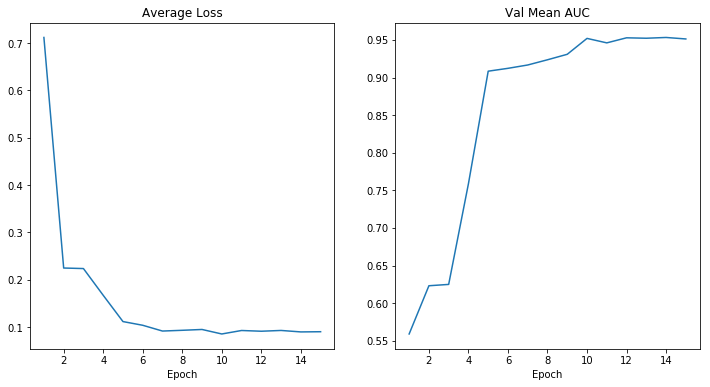

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean AUC")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Epoch")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

After training is completed, we use the best validation checkpoint to test the model performance on the Open-I testing set. 

In [11]:
model.load_state_dict(torch.load(os.path.join(logdir, "transchex.pt"))["state_dict"])
model.eval()
with torch.no_grad():
    auc_val, loss_val, auc = validation(test_loader)

print(
    "\nMean test AUC for each class in 14 disease categories\
    :\n\nAtelectasis: {}\nCardiomegaly: {}\nConsolidation: {}\nEdema: \
    {}\nEnlarged-Cardiomediastinum: {}\nFracture: {}\nLung-Lesion: {}\nLung-Opacity: \
    {}\nNo-Finding: {}\nPleural-Effusion: {}\nPleural_Other: {}\nPneumonia: \
    {}\nPneumothorax: {}\nSupport-Devices: {}".format(
        auc[0],
        auc[1],
        auc[2],
        auc[3],
        auc[4],
        auc[5],
        auc[6],
        auc[7],
        auc[8],
        auc[9],
        auc[10],
        auc[11],
        auc[12],
        auc[13],
    )
)

Evaluation Statistics: Mean AUC : 0.9629915902329793, Mean Loss : 0.06937971694082447

Mean test AUC for each class in 14 disease categories    :

Atelectasis: 0.9933158010081088
Cardiomegaly: 0.974534284581847
Consolidation: 0.9532794249775381
Edema:     0.9901960784313726
Enlarged-Cardiomediastinum: 0.9449934738019765
Fracture: 0.9911196911196911
Lung-Lesion: 0.9471389645776568
Lung-Opacity:     0.986452330401375
No-Finding: 0.9574158854734394
Pleural-Effusion: 0.8975490196078432
Pleural_Other: 0.9973118279569892
Pneumonia:     0.9714795008912656
Pneumothorax: 0.9787234042553191
Support-Devices: 0.8983725761772853


This tutorial demonstrates the effectiveness of TransCheX model for multi-modal training using chest X-ray images and corrersponding reports. By using the Open-I dataset, we demonstrate how TransCheX model can be leveraged for multi-label classification problems involing 2 different modalities of data. 

As seen above, the mean AUC for the test dataset is 0.9629 which is 1.007% better than the best validation mean AUC.